In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [2]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "%Y-%m-%d %H:%M:%S")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [6]:
hydra.reset()
multiplier = 2
st = time.perf_counter_ns()
close = AssetReadNode.make("Close", 0, exchange)
previous_close = AssetReadNode.make("Close", -1, exchange)

atr_node = ATRNode.make(
    exchange,
    "High",
    "Low",
    14
) 
median_node = AssetMedianNode.make(
    exchange,
    "High",
    "Low",
)
upper_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.ADD
)
upper_left_cond = AssetIfNode(
    upper_band,
    AssetCompType.LESS,
    DummyNode(exchange)
)
upper_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.GREATER, 
    DummyNode(exchange)
)
final_upper_band = AssetCompNode(
    upper_left_cond,
    LogicalType.OR,
    upper_right_cond,
    upper_band,
    DummyNode(exchange)
)
lagged_final_upper_band = final_upper_band.lag(1)
upper_left_cond.swapRightEval(lagged_final_upper_band)
upper_right_cond.swapRightEval(lagged_final_upper_band)
final_upper_band.swapFalseEval(lagged_final_upper_band)
exchange.enableNodeCache("final_upper_band",final_upper_band)
et = time.perf_counter_ns()
print(f"Time to build: {(et-st)/1e6}ms")

Time to build: 0.8382ms


In [4]:
path = os.path.join(exchange_path,"BTC-USD.csv")  
df = pd.read_csv(path)
df["upper_band"] = final_upper_band.cache()[0]

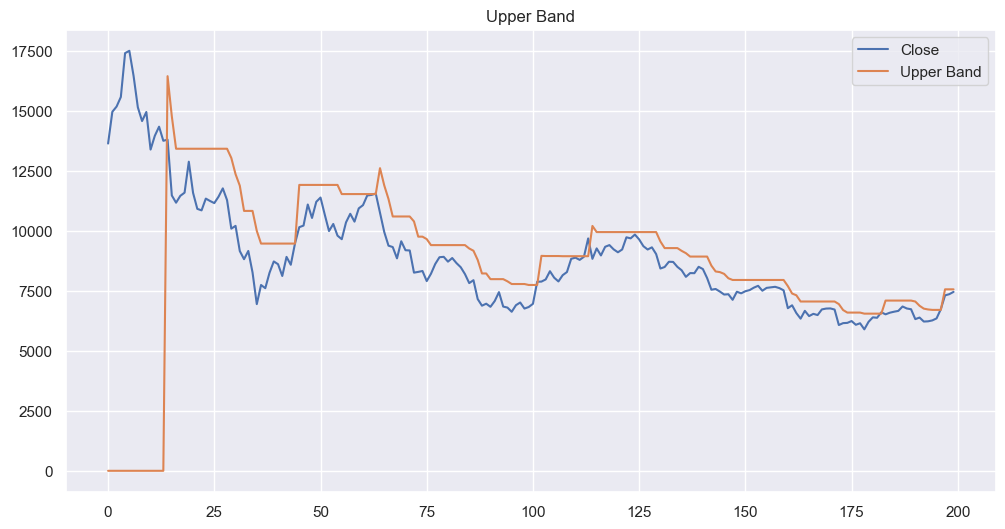

In [5]:
n = 200
df_sub = df.iloc[:n]
plt.figure(figsize=(12,6))
plt.plot(df_sub["Close"], label="Close")
plt.plot(df_sub["upper_band"], label="Upper Band")
plt.title("Upper Band")
plt.legend()
plt.show()